# Copia: quickstart

In [1]:
import pandas as pd
df = pd.read_csv('../datasets/dum.csv', sep=';', header=None)
df.columns = 'work', 'signature'
df.head()

,work,signature
0,Aiol (1),"Leiden, UB, BPL 1049; Brussel, KB, IV 816"
1,Aiol (2),"Breda, Arch. Begijnhof, z.s."
2,Alexanders geesten,"München, Bayerische Staatsbibliotheek, Cod. ge..."
3,Alexanders geesten,"Gent, UB, 2749,6"
4,Alexanders geesten,"Leiden, UB, Ltk. 1196"


Convert to abundance data:

In [2]:
from copia.utils import to_abundance
works = df['work']
abundance = to_abundance(works)
print(abundance)
print(abundance.sum())

[ 1  1  5  2  1  2  1  1  2  2  3  3  1  1  2  1  1  1  1  2  1  1  1  1
  1  1  4  1  1  7  1  1  3  1 10  1  3  2 10  4  2  1  3  6  5  2  5  2
  5  1  1  1  1  1  2 17  2  1  1  2  1  1  1  3  1  1  1  1  1  1  1  1
  1  1  1]
167


In [3]:
from copia.richness import species_accumulation
accumulation = species_accumulation(abundance, max_steps=4000, n_iter=100)

100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


<AxesSubplot:title={'center':'species accumulation curve'}, xlabel='documents', ylabel='works'>

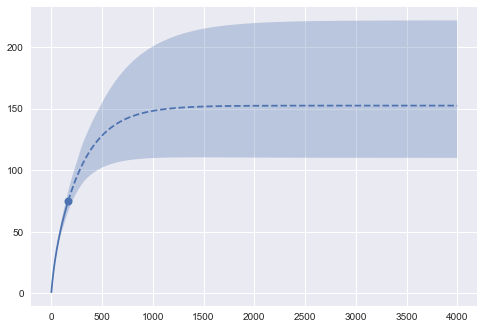

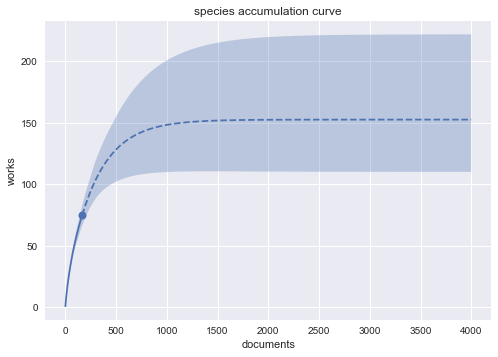

In [4]:
from copia.plot import accumulation_curve
accumulation_curve(abundance, accumulation)
accumulation_curve(abundance, accumulation,
                   xlabel='documents', ylabel='works',
                   title='species accumulation curve')

100%|██████████| 1000/1000 [00:01<00:00, 608.74it/s]


<AxesSubplot:title={'center':'Minsample included'}, xlabel='documents', ylabel='works'>

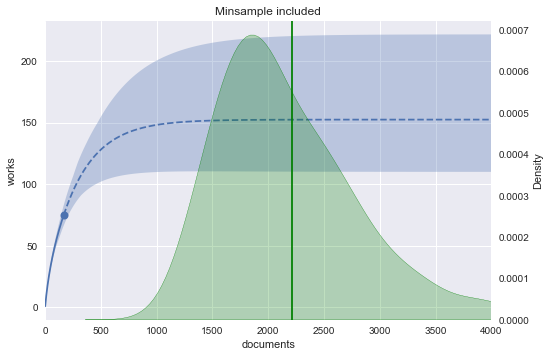

In [5]:
from copia.richness import diversity
minsample_est = diversity(abundance, method='minsample', 
                          solver='fsolve', CI=True)
accumulation_curve(abundance, accumulation, title='Minsample included',
                   xlabel='documents', ylabel='works',
                   minsample=minsample_est, xlim=(0, 4000))

<AxesSubplot:xlabel='$x$', ylabel='h(x) and v(x)'>

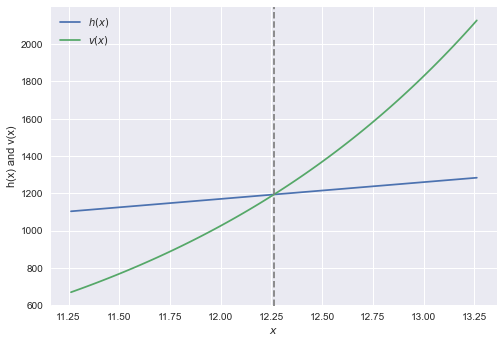

In [6]:
diagnostics = diversity(abundance, method='minsample', 
                        solver='fsolve', CI=False, # CI must be False for this use!
                        diagnostics=True)
from copia.plot import minsample_diagnostic_plot
minsample_diagnostic_plot(abundance, diagnostics)

In [7]:
from copia.richness import diversity
print(diversity(abundance, method='minsample'))
print(diversity(abundance, method='minsample', solver='grid'))
print(diversity(abundance, method='minsample', solver='fsolve'))
print(diversity(abundance, method='minsample', solver='grid', tolerance=1e-10))

2214.756047756048
2214.756047756048
2214.754452813089
2214.756047756048


/Users/mikekestemont/GitRepos/copia/copia/richness.py:447: UserWarning: Tolerance criterion not met: 0.005726762492940907 > 1e-10
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


In [8]:
assemblage = ['A', 'B', 'C']
assemblage += ['D'] * 2 + ['E'] * 2
assemblage += ['F'] * 3 + ['G'] * 3 + ['H'] * 3
assemblage += ['I'] * (161 - len(assemblage))

import copia.utils as u
x = u.to_abundance(assemblage)
print(diversity(x, method='minsample', solver='grid', diagnostics=True))

{'richness': 518.5974575974576, 'x*': 2.221102221102221, 'n': 161}


In [9]:
print(diversity(abundance, method='minsample', solver='grid', diagnostics=True))

{'richness': 2214.756047756048, 'x*': 12.262012262012263, 'n': 167}


In [10]:
from copia.hill import hill_numbers
emp, est = hill_numbers(abundance)

100%|██████████| 1000/1000 [00:16<00:00, 61.23it/s]


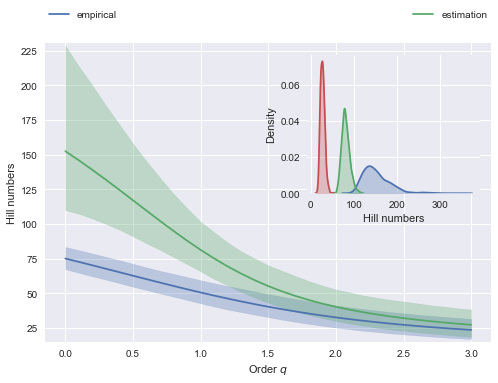

In [11]:
import copia.plot as plot
plot.hill_plot(emp, est);

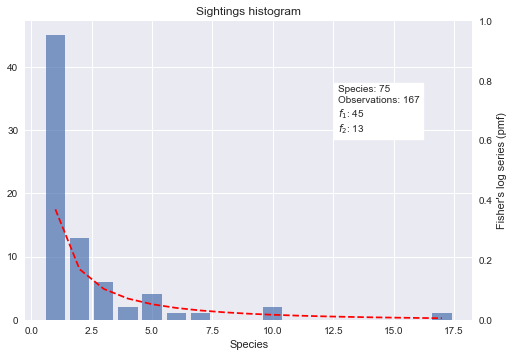

In [12]:
plot.abundance_histogram(abundance);

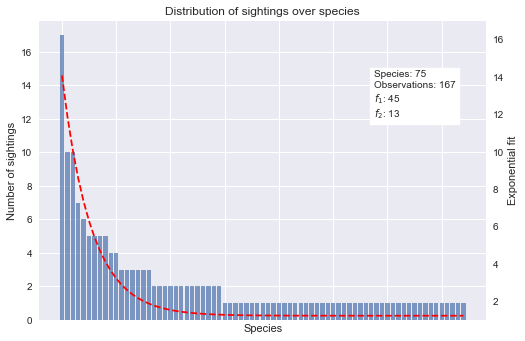

In [13]:
plot.abundance_counts(abundance);

Apply chao1:

In [14]:
from copia.richness import diversity
print('Empirical (species):', diversity(abundance)) # = diversity(abundance, method='empirical')
print('Empirical (sightings):', diversity(abundance, species=False))
print('chao1:', diversity(abundance, method='chao1'))
print('iChao1:', diversity(abundance, method='iChao1'))
print('ACE:', diversity(abundance, method='ACE'))
print('Egghe & Proot:', diversity(abundance, method='egghe_proot'))
print('Jackknife:', diversity(abundance, method='jackknife'))

Empirical (species): 75
Empirical (sightings): 167
chao1: 152.41824044219254
iChao1: 171.54324044219254
ACE: 152.3244760991645
Egghe & Proot: 170.30024512537264
Jackknife: 177.0


In [15]:
print(diversity(abundance, method='jackknife', return_order=True))
print(diversity(abundance, method='jackknife', return_order=True, CI=True))
print(diversity(abundance, method='jackknife', CI=True, conf=.89))
print(diversity(abundance, method='jackknife', return_order=False,
               CI=True, conf=.89))

{'richness': 177.0, 'order': 3}
{'richness': 177.0, 'order': 3, 'lci': 127.80529442066658, 'uci': 226.1947055793334}
{'richness': 177.0, 'lci': 136.88567055436792, 'uci': 217.11432944563208}
{'richness': 177.0, 'lci': 136.88567055436792, 'uci': 217.11432944563208}


In [16]:
print(diversity(abundance, method='minsample'))
print(diversity(abundance, method='minsample', solver='grid'))
print(diversity(abundance, method='minsample', solver='fsolve'))
print(diversity(abundance, method='minsample', solver='grid', tolerance=1e-10))

2214.756047756048
2214.756047756048
2214.754452813089
2214.756047756048


/Users/mikekestemont/GitRepos/copia/copia/richness.py:447: UserWarning: Tolerance criterion not met: 0.005726762492940907 > 1e-10
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


In [17]:
print(diversity(abundance, method='minsample', solver='fsolve', diagnostics=True))

{'richness': 2214.754452813089, 'x*': 12.262002711455622, 'n': 167}


## Compare multiple assemblages

In [18]:
import pandas as pd
import copia.plot as plot
from copia.utils import to_abundance, survival_ratio

assemblages = {}
for lang in ('dum', 'isl', 'gle', 'eng'):
    works = pd.read_csv(f'../datasets/{lang}.csv', sep=';',
                        header=None).iloc[:, 0]
    assemblages[lang] = to_abundance(works)

In [19]:
survival = {}
for lang, assemblage in assemblages.items():
    survival[lang] = survival_ratio(assemblage)

100%|██████████| 1000/1000 [00:00<00:00, 2056.56it/s]


<AxesSubplot:>

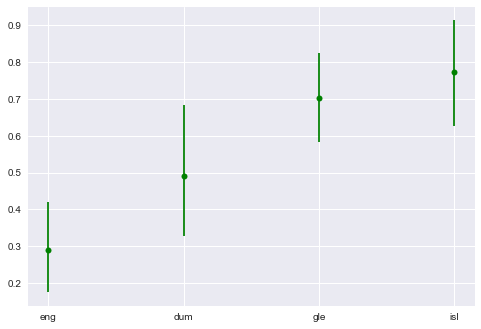

In [20]:
plot.survival_errorbar(survival)

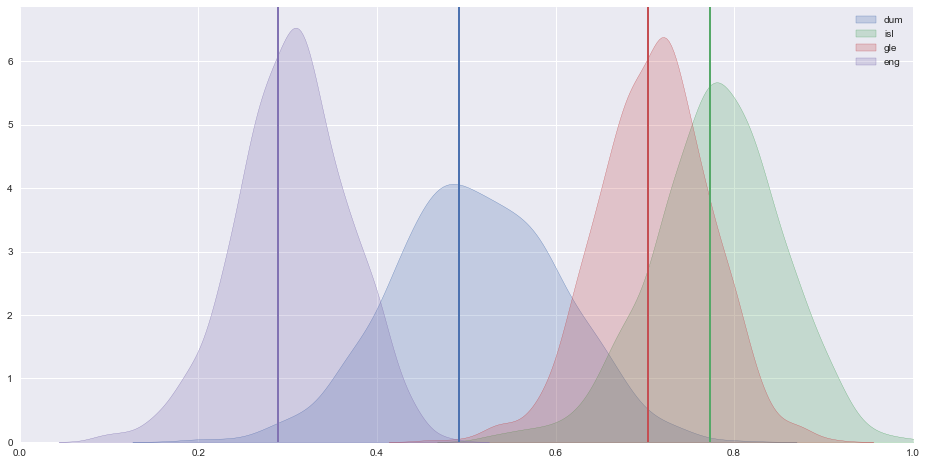

In [21]:
plot.multi_kde(survival);

100%|██████████| 1000/1000 [00:00<00:00, 2069.44it/s]


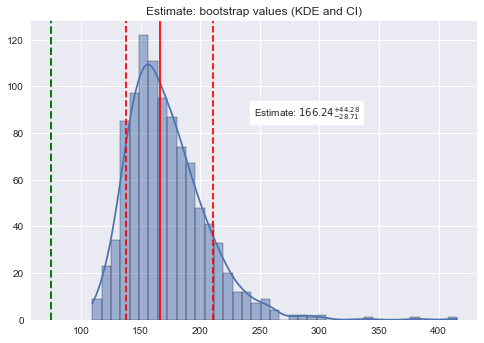

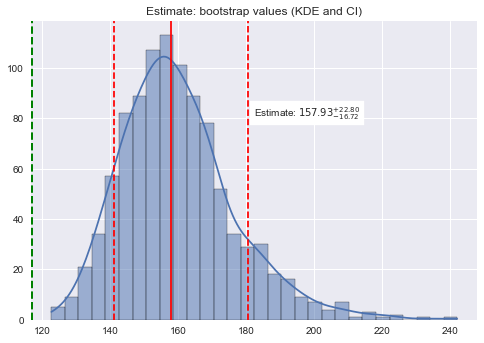

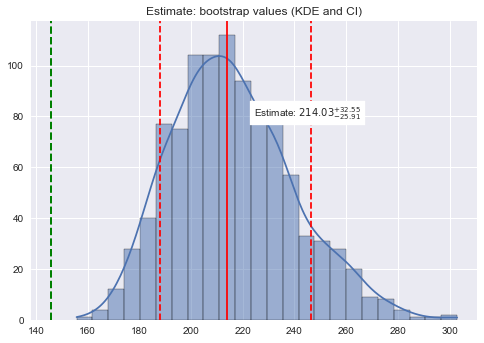

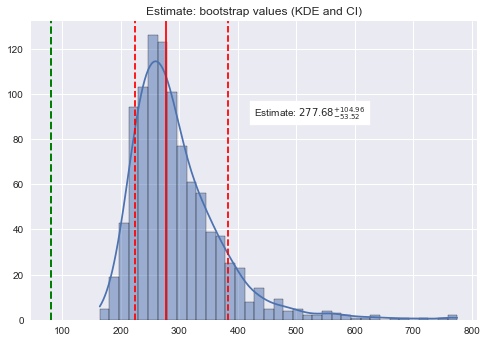

In [22]:
from copia.richness import diversity
for lang, assemblage in assemblages.items():
    empirical = diversity(assemblage, method='empirical')
    estimate = diversity(assemblage, method='iChao1', CI=True)
    plot.density(estimate, empirical)

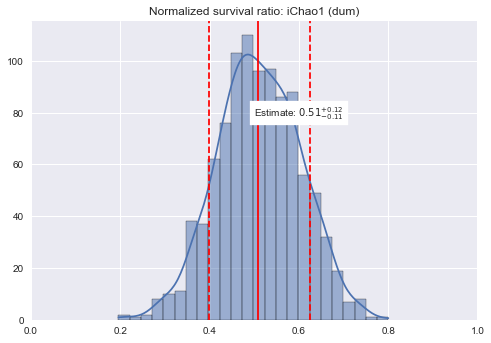

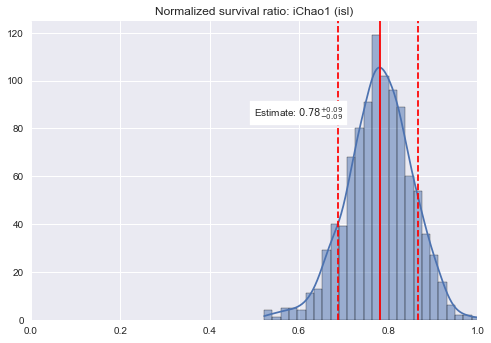

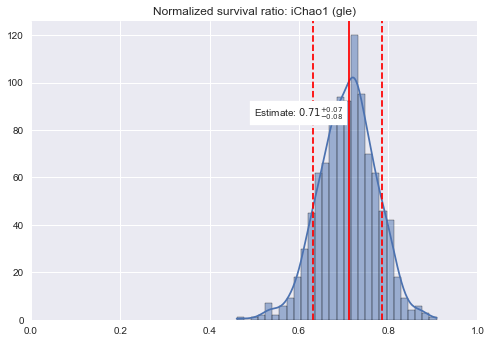

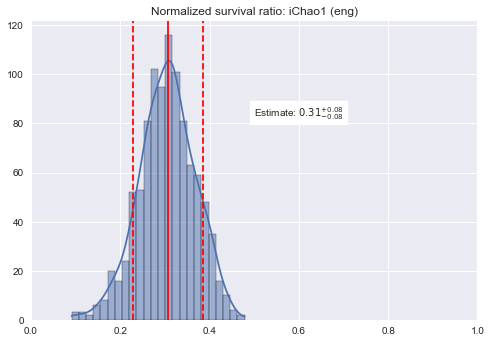

In [23]:
for lang, assemblage in survival.items():
    plot.density(assemblage, xlim=(0, 1), title=f'Normalized survival ratio: iChao1 ({lang})')

100%|██████████| 1000/1000 [00:19<00:00, 52.33it/s]


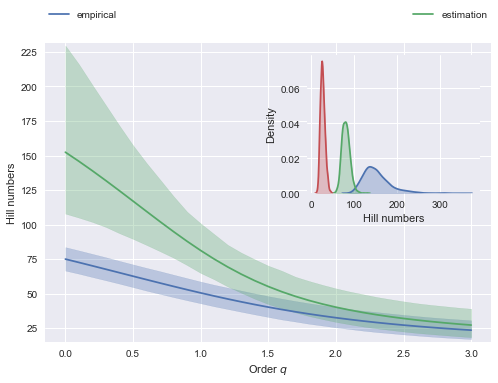

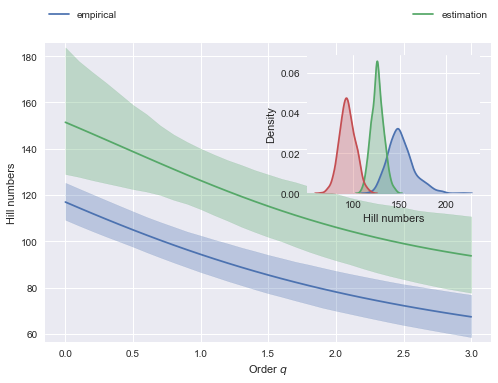

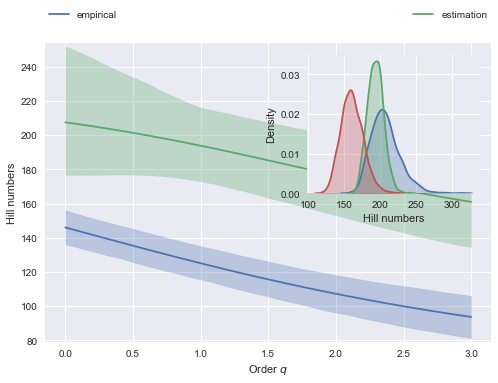

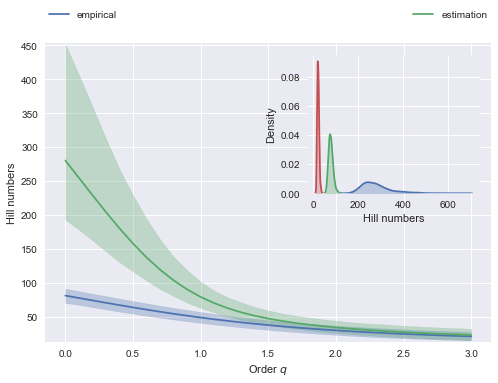

In [24]:
import copia.plot as plot
from copia.hill import hill_numbers

hill_est = {}
for lang, assemblage in assemblages.items():
    emp, est = hill_numbers(assemblage)
    plot.hill_plot(emp, est)
    hill_est[lang] = est

In [25]:
from copia.utils import evenness
evennesses = {l:evenness(hill_est[l]) for l in hill_est}

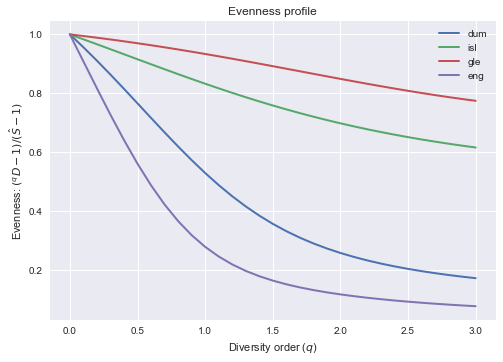

In [26]:
plot.evenness_plot(evennesses);